# Equalizador Não Linear para um Sistema de Comunicações Ópticos Utilizando Redes Neurais

In [2]:
import numpy as np
from commpy.utilities  import upsample
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.comm.metrics import  theoryBER
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power

try:
    from optic.dsp.coreGPU import firFilter    
except ImportError:
    from optic.dsp.core import firFilter
    
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram, pconst
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp



In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [4]:
# %load_ext autoreload
# %autoreload 2

In [5]:
np.random.seed(seed=123)

# Simulação de um Sistema Óptico para treinamento da Rede Neural

Formato do array de bits:  (2000000,)
Formato do array dos bits modulados em PAM:  (1000000,)
Formato do array depois do upsampling  (16000000,)
Formato do array depois da formataç~~ao de pulso:  (16000000,)
Potência média do sinal ótpico modulado [mW]: 0.500 mW
Potência média do sinal óptico modualdo [dBm: -3.009 dBm]
Quantidade de bits:  2000000


C:\Users\jezra\anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jezra\anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


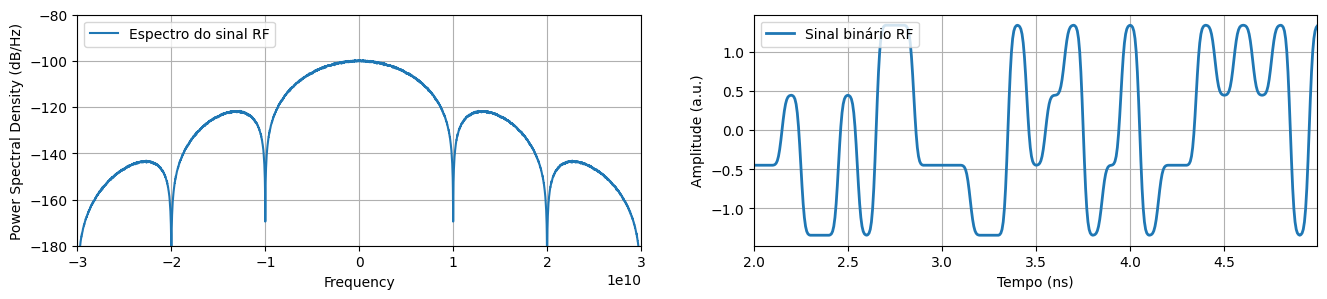

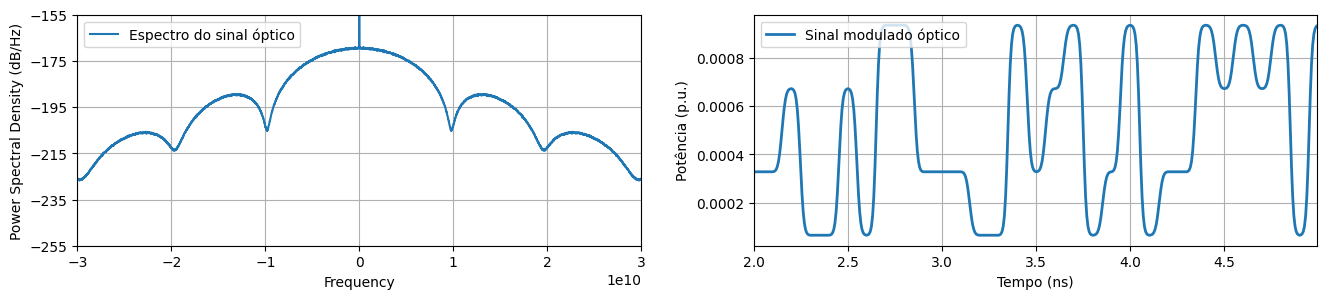

In [5]:
# Parâmetros para simulação
Sps = 16  # Amostras por símbolo
M = 4              # Ordem do formato de modulação
Rs = 10e9          # taxa de símbolos
Fs = Sps*Rs        # taxa de amostragem
Ts = 1/Fs          #Intervalo de amostragem

#Potência do laser na entrada do modulador Mach-Zehnder em dbm e W
Pi_dbm = 0
Pi_W = dBm2W(Pi_dbm)

#Parâmetros do Mach-Zehnder
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

#Sequência de bits aleatórios
bitsTx = np.random.randint(2, size = int(np.log2(M)*1e6))
print("Formato do array de bits: ", bitsTx.shape)

#Sequência de símbolos modulados em OOK
symbTx = modulateGray(bitsTx, M, 'pam')    
symbTx = pnorm(symbTx) # normaliza a potência
print("Formato do array dos bits modulados em PAM: ", symbTx.shape)

#upsampling
symbUp = upsample(symbTx, Sps)
print("Formato do array depois do upsampling ", symbUp.shape)

#Pulso NRZ
pulse = pulseShape('nrz', Sps)
pulse = pulse/max(abs(pulse))

#Formatação de pulso
sigTx = firFilter(pulse, symbUp)
print("Formato do array depois da formataç~~ao de pulso: ", sigTx.shape)

#Modulação óptica
Ai = np.sqrt(Pi_W)
sigTxo = mzm(Ai, 0.5*sigTx, paramMZM)

print('Potência média do sinal ótpico modulado [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modualdo [dBm: %.3f dBm]'%(10*np.log10(signal_power(sigTxo)/1e-3)))
print('Quantidade de bits: ', len(bitsTx))
fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

#Plot da PSD
axs[0].set_xlim(-3*Rs, 3*Rs);
axs[0].set_ylim(-180, -80);
axs[0].psd(sigTx, Fs = Fs, NFFT = 16*1024, sides = 'twosided', label = 'Espectro do sinal RF')
axs[0]. legend(loc = 'upper left');

axs[1].plot(t, sigTx[interval], label = 'Sinal binário RF', linewidth = 2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-255,-155);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Sinal modulado óptico', linewidth=2)
axs[1].set_ylabel('Potência (p.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

In [6]:
# Canal óptico linear
paramCh = parameters()
paramCh.L = 80         # Distância [km]
paramCh.α = 0.2        # Parâmetro de perdas da fibra [dB/km]
paramCh.D = 16         # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.Fc = 193.1e12  # Frequência óptica central [Hz]
paramCh.Fs = Fs        # Frequência de amostragem da simulação [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

# Pré-amplificador do receptor
paramEDFA = parameters()
paramEDFA.G = paramCh.α*paramCh.L    # ganho edfa
paramEDFA.NF = 4.6   # edfa noise figure 
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

sigCh = edfa(sigCh, paramEDFA)

Formato do array no final do canal (16000000,)


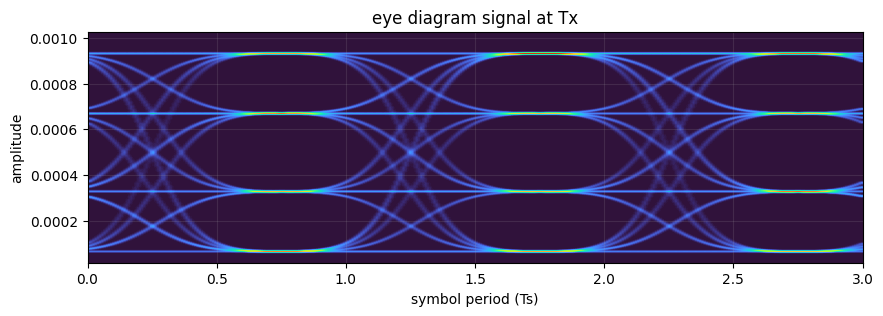

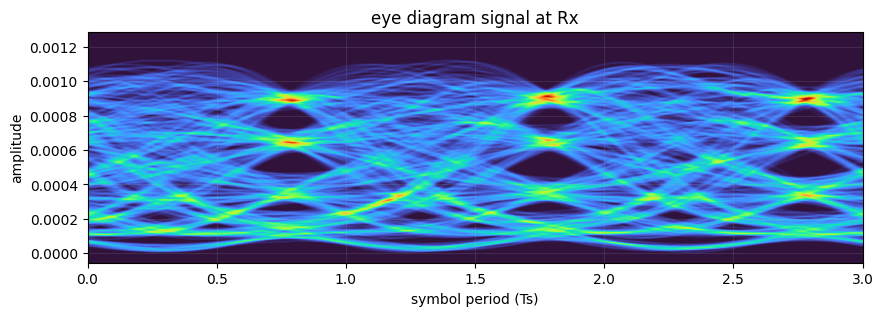

In [61]:
# fotodiodo ideal (sem ruído e limitação de banda)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs
I_Rx_ideal = photodiode(sigTxo.real, paramPD)

# noisy photodiode (ruídos térmico e de disparo + limitação de banda)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

I_Rx = photodiode(sigCh, paramPD)
print("Formato do array no final do canal", I_Rx.shape)
discard = 100

eyediagram(I_Rx_ideal[discard:-discard], I_Rx.size-2*discard, Sps, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, Sps, plotlabel='signal at Rx', ptype='fancy')

Formato depois de dividir por std:  (16000000,)
Formato do array depois da seleção dos valores em SPS:  (1000000,)
Formato do array depois da normalização:  (1000000,)
Formato do array ddepois da demodulação:  (2000000,)
Number of counted errors = 165 
BER = 8.25e-05 


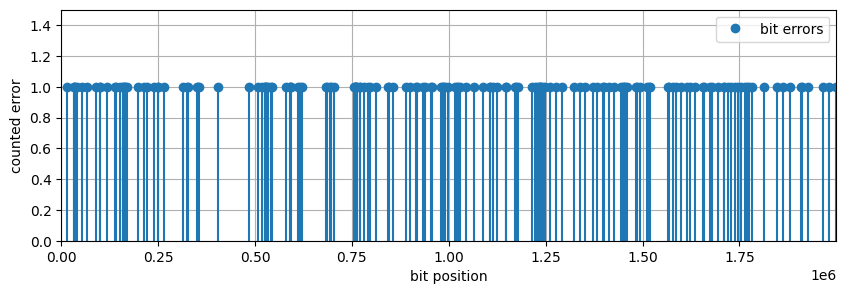

In [8]:
#Normaliza o sinal e seleciona os valores no intervalo de sinalização
I_Rx = I_Rx/np.std(I_Rx)
print("Formato depois de dividir por std: ", I_Rx.shape)
symbRx = I_Rx[0::Sps]
print("Formato do array depois da seleção dos valores em SPS: ", symbRx.shape)

#Tira o nível DC e normaliza a potência
symbRx = symbRx - symbRx.mean()
symbRx = pnorm(symbRx)
print("Formato do array depois da normalização: ", symbRx.shape)

# Demodula os símbolos para bits usando a mínima distância euclidiana 
const = GrayMapping(M,'pam') 
Es = signal_power(const) 

bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, 'pam')
print("Formato do array ddepois da demodulação: ", bitsRx.shape)

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

#Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
#print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

# Segunda Simulação, para Teste da Rede Neural

C:\Users\jezra\anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\jezra\anaconda3\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


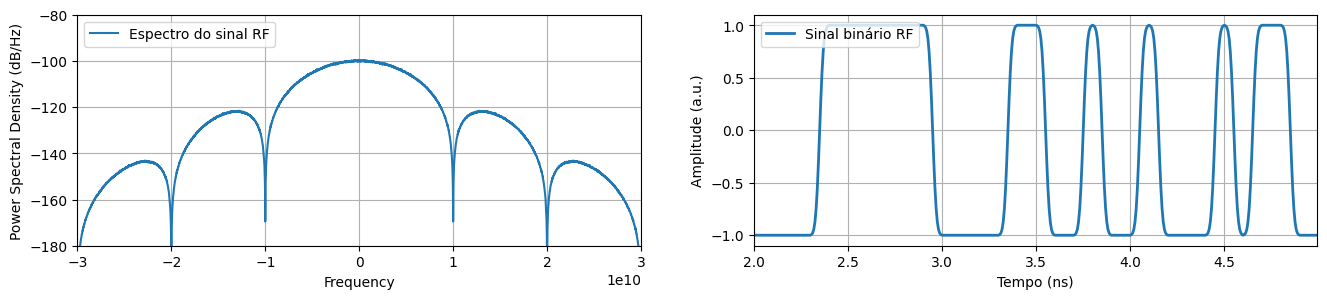

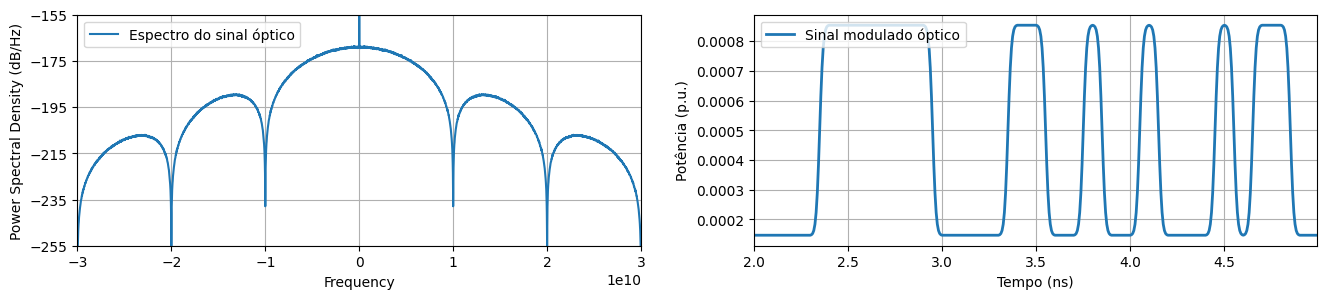

In [7]:

Sps2 = 16  # Amostras por símbolo
M2 = 2              # Ordem do formato de modulação
Rs2 = 10e9          # taxa de símbolos
Fs2 = Sps2*Rs2        # taxa de amostragem
Ts2 = 1/Fs2          #Intervalo de amostragem

#Potência do laser na entrada do modulador Mach-Zehnder em dbm e W
Pi_dbm2 = 0
Pi_W2 = dBm2W(Pi_dbm2)

#Parâmetros do Mach-Zehnder
paramMZM2 = parameters()
paramMZM2.Vpi = 2
paramMZM2.Vb = -paramMZM2.Vpi/2

#Sequência de bits aleatórios
bitsTx2 = np.random.randint(2, size = int(np.log2(M2)*1e6))

#Sequência de símbolos modulados em OOK
symbTx2 = modulateGray(bitsTx2, M2, 'pam')    
symbTx2 = pnorm(symbTx2) # normaliza a potência

#upsampling
symbUp2 = upsample(symbTx2, Sps2)

#Pulso NRZ
pulse2 = pulseShape('nrz', Sps2)
pulse2 = pulse2/max(abs(pulse2))

#Formatação de pulso
sigTx2 = firFilter(pulse2, symbUp2)

#Modulação óptica
Ai2 = np.sqrt(Pi_W2)
sigTxo2 = mzm(Ai2, 0.5*sigTx2, paramMZM2)

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts2/1e-9

#Plot da PSD
axs[0].set_xlim(-3*Rs2, 3*Rs2);
axs[0].set_ylim(-180, -80);
axs[0].psd(sigTx2, Fs = Fs2, NFFT = 16*1024, sides = 'twosided', label = 'Espectro do sinal RF')
axs[0]. legend(loc = 'upper left');

axs[1].plot(t, sigTx2[interval], label = 'Sinal binário RF', linewidth = 2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs2,3*Rs2);
axs[0].set_ylim(-255,-155);
axs[0].psd(np.abs(sigTxo2)**2, Fs=Fs2, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo2[interval])**2, label = 'Sinal modulado óptico', linewidth=2)
axs[1].set_ylabel('Potência (p.u.)')
axs[1].set_xlabel('Tempo (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

In [55]:
print(np.array_equal(bitsTx, bitsTx2))

False


In [17]:
# Canal óptico linear
paramCh2 = parameters()
paramCh2.L = 120         # Distância [km]
paramCh2.α = 0.2        # Parâmetro de perdas da fibra [dB/km]
paramCh2.D = 17         # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh2.Fc = 193.1e12  # Frequência óptica central [Hz]
paramCh2.Fs = Fs2        # Frequência de amostragem da simulação [samples/second]

sigCh2 = linearFiberChannel(sigTxo2, paramCh2)

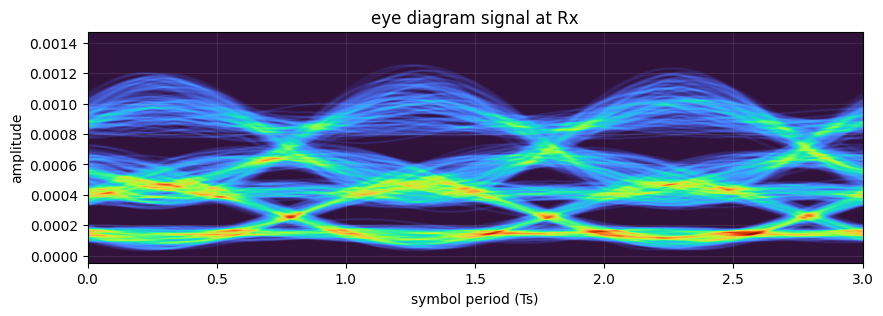

In [18]:
# Pré-amplificador do receptor
paramEDFA2 = parameters()
paramEDFA2.G = paramCh2.α*paramCh2.L    # ganho edfa
paramEDFA2.NF = 4.5   # edfa noise figure 
paramEDFA2.Fc = paramCh2.Fc
paramEDFA2.Fs = Fs2

sigCh2 = edfa(sigCh2, paramEDFA2)

#Fotodiodo não-linear
paramPD2 = parameters()
paramPD2.ideal = False
paramPD2.B = Rs2
paramPD2.Fs = Fs2

I_Rx2 = photodiode(sigCh2, paramPD2)
discard = 100
eyediagram(I_Rx2[discard:-discard], I_Rx2.size-2*discard, Sps2, plotlabel='signal at Rx', ptype='fancy')

Number of counted errors = 563 


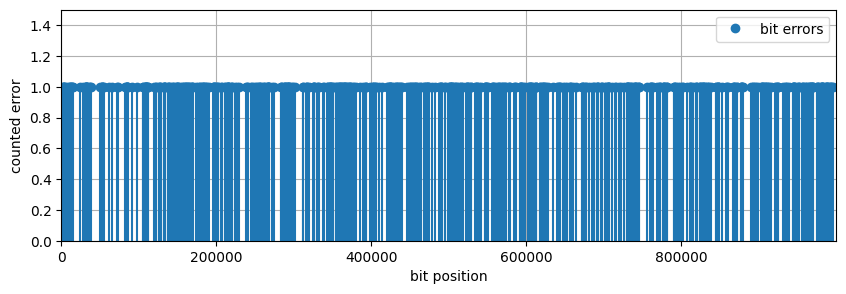

In [19]:
I_Rx2 = I_Rx2/np.std(I_Rx2)
symbRx2 = I_Rx2[0::Sps2]

#Tira o nível DC e normaliza a potência
symbRx2 = symbRx2 - symbRx2.mean()
symbRx2 = pnorm(symbRx2)

# Demodula os símbolos para bits usando a mínima distância euclidiana 
const2 = GrayMapping(M2,'pam') 
Es2 = signal_power(const2) 

bitsRx2 = demodulateGray(np.sqrt(Es2)*symbRx2, M2, 'pam')

discard = 100
err2 = np.logical_xor(bitsRx2[discard:bitsRx2.size-discard], bitsTx2[discard:bitsTx2.size-discard])
BER2 = np.mean(err2)
print('Number of counted errors = %d '%(err2.sum()))
err2 = err2*1.0
err2[err2==0] = np.nan

plt.plot(err2,'o', label = 'bit errors')
plt.vlines(np.where(err2>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err2.size);

# Criando um Conjunto de Dados para Alimentar a Rede Neural

In [20]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from optic.torchUtils import slidingWindowDataSet, MLP

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [21]:
# Define o número de taps e de amostras por símbolo
Ntaps = 64
SpS_in = 16
SpS_out = 1
Nsymbols = len(symbTx)

batch_size = 64
shuffle = False

# Pré-processamento dos dados

#Dados de treino (1ª Simulação)
signal_train_full = pnorm(I_Rx[0::SpS_in//SpS_out])   #Recupera o sinal nos intervalos de sinalização
signal_train = pnorm(I_Rx[0:Nsymbols*SpS_in:SpS_in//SpS_out])
symbols_train = pnorm(symbTx[0:Nsymbols])   #Símbolos a serem passados como alvo do equalizador

signal_train = (signal_train - np.mean(signal_train))/np.std(signal_train)
signal_train_full = (signal_train_full - np.mean(signal_train_full))/np.std(signal_train_full)
symbols_train = (symbols_train - np.mean(symbols_train))/np.std(symbols_train)

#Dados de Teste (2ª Simulação)
signal_test_full = pnorm(I_Rx2[0::SpS_in//SpS_out])   
signal_test = pnorm(I_Rx2[0:Nsymbols*SpS_in:SpS_in//SpS_out])
symbols_test = pnorm(symbTx2[0:Nsymbols])

signal_test = (signal_test - np.mean(signal_test))/np.std(signal_test)
signal_test_full = (signal_test_full - np.mean(signal_test_full))/np.std(signal_test_full)
symbols_test = (symbols_test - np.mean(symbols_test))/np.std(symbols_test)

symbols_train = symbols_train.reshape(-1,1)
symbols_test = symbols_test.reshape(-1, 1)


#Criação dos Datasets
train_dataset = slidingWindowDataSet(signal_train, symbols_train, Ntaps, SpS_out)
test_dataset = slidingWindowDataSet(signal_test, symbols_test, Ntaps, SpS_out)

#Criação dos Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)



NameError: name 'symbTx' is not defined

# Criação de uma rede neural para equalização

# Treinamento da rede com dados da simulação

In [ ]:
def train_loop(dataloader, model, loss, optimizer):
    size = len(dataloader.dataset)
    
    cada_print = size/5
    
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x = x.float()
        predict = model(x)
        loss_value = loss(predict, y)
        
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % cada_print == 0:
            loss_value, current = loss_value.item(), (batch+1)*len(x)
            print(f"loss: {loss_value:>7f}[{current:>5d}/{size:>5d}]" )